# <center><b>ROAD</b></center>

# <center><b>CLASSIFICATION</b></center>

![road.jpg](attachment:road.jpg )
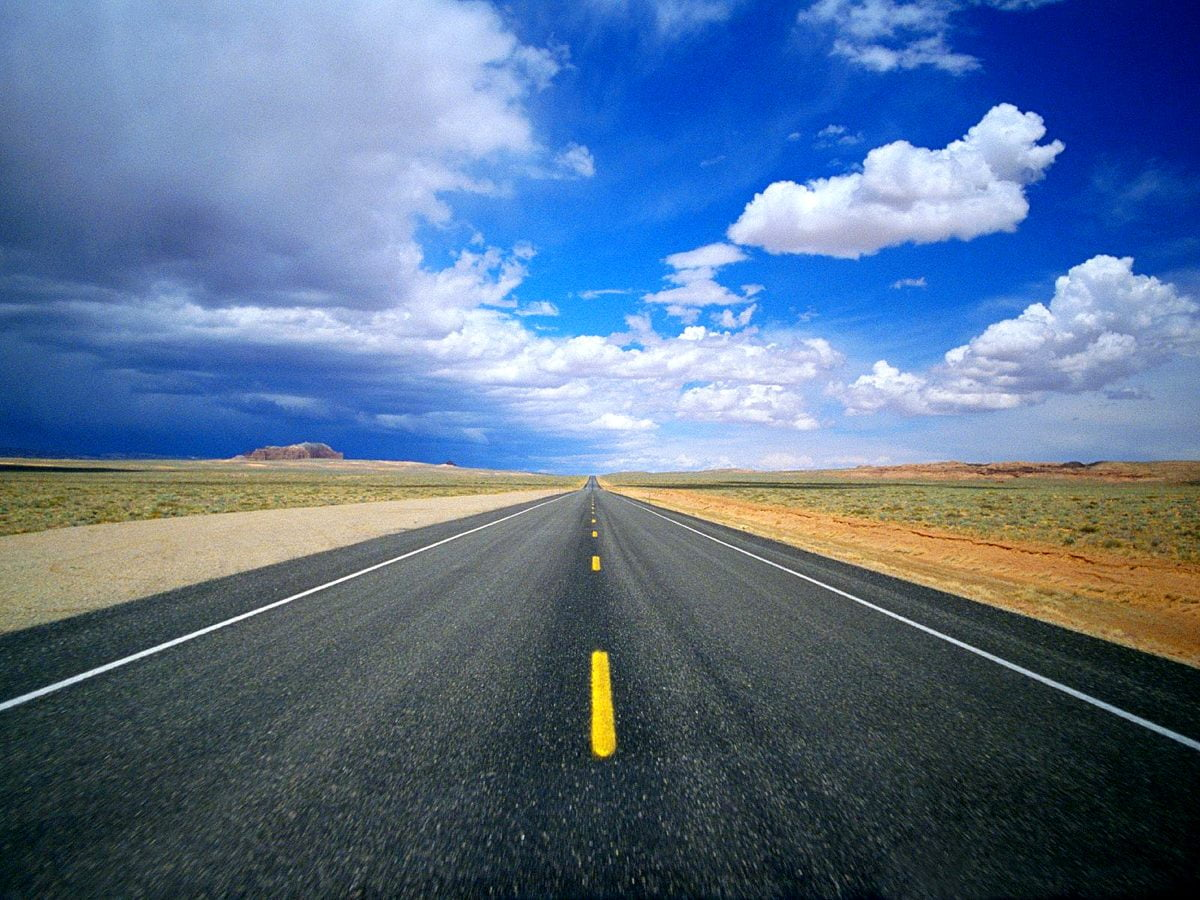

<center>The task is to create a classification model, which can accurately classify if a road is clean or littered</center>

### Importing Libraries

In [407]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
import cv2
import tensorflow as tf
import keras
from keras.layers import Dense, MaxPooling2D, Conv2D, BatchNormalization, Dropout, Input, Flatten
from keras.models import Sequential, Model
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from random import randint
from tensorflow.keras.applications import MobileNetV2, MobileNet

In [408]:
# meta/images paths
meta_file= r"C:\Users\DELL\Documents\My Learning\new portfolio projects\datasets\road dataset\metadata.csv"
IMAGE_PATH = r"C:\Users\DELL\Documents\My Learning\new portfolio projects\datasets\road dataset\Images\Images"

In [409]:
# load meta
df = pd.read_csv(meta_file)
# creating column for filepath of every image in the dataset
df['filepath'] = df['filename'].map(lambda x:  os.path.join(IMAGE_PATH,x))

In [410]:
df.head()

,filename,label,filepath
0,dirty_2.jpg,1,C:\Users\DELL\Documents\My Learning\new portfo...
1,clean_36.jpg,0,C:\Users\DELL\Documents\My Learning\new portfo...
2,clean_31.jpg,0,C:\Users\DELL\Documents\My Learning\new portfo...
3,dirty_69.jpg,1,C:\Users\DELL\Documents\My Learning\new portfo...
4,clean_113.jpg,0,C:\Users\DELL\Documents\My Learning\new portfo...


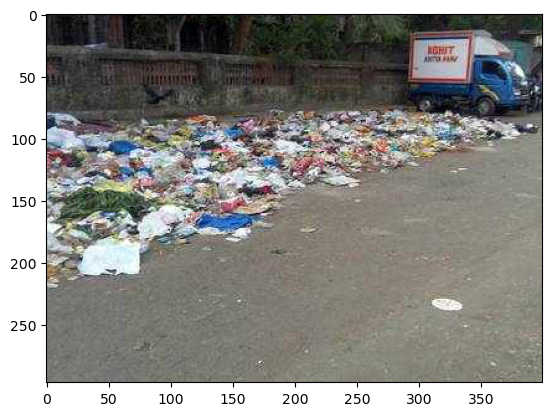

In [411]:
plt.imshow(plt.imread(df['filepath'][0]));

#### Visualization

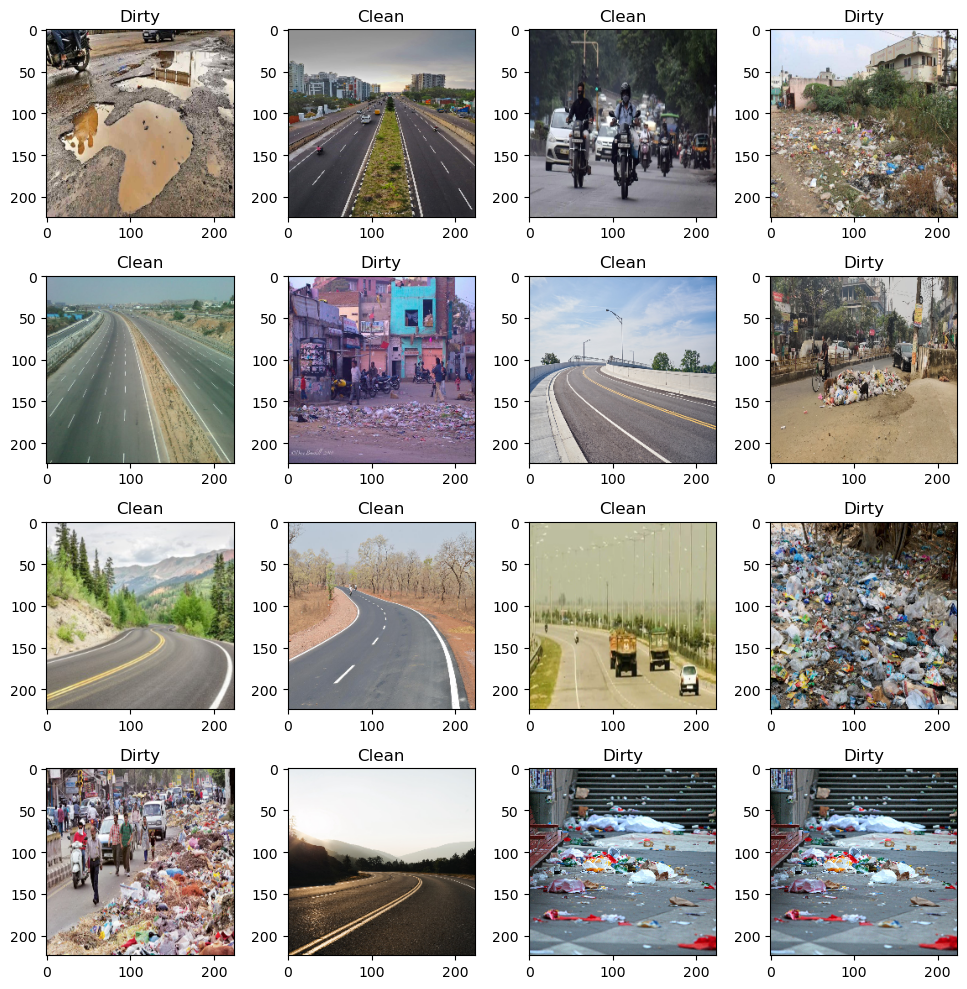

In [412]:
plt.figure(figsize = (10,10))
for val in range(16):
    i = random.randint(0,len(df))
    plt.subplot(4, 4, val + 1)
    image = plt.imread(df['filepath'][i])
    image = cv2.resize(image, (224, 224))
    label = df['label'][i]
    plt.title("Clean" if label == 0 else "Dirty")
    plt.axis()
    plt.tight_layout()
    plt.imshow(image)
    
    

In [413]:
df['label'] = df['label'].astype(str)#

In [414]:
num_classes = df['label'].nunique()
num_classes

2

In [415]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size = 0.2, random_state=42) 

In [416]:
IMG_SHAPE = 400
BATCH_SIZE = 32

In [417]:
train_gen=ImageDataGenerator(rescale=1/255.,
                        brightness_range=[0.4,1.4],
                        rotation_range =10 ,
                        zoom_range = 0.1,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        horizontal_flip=True,
                            vertical_flip=True)

test_gen=ImageDataGenerator(rescale=1/255.)

In [418]:
train_df = train_gen.flow_from_dataframe(
            train, 
            target_size =(224,224), 
            x_col='filepath',
            y_col='label',
            batch_size= BATCH_SIZE, 
            class_mode="sparse" ,
            color_mode = 'rgb',
            shuffle = True
            )

test_df = test_gen.flow_from_dataframe(
            test,
            color_mode = 'rgb',
            target_size = (224,224), 
            shuffle = True,
            x_col='filepath',y_col='label',
            batch_size= 64,
            class_mode="sparse" 
            )
        

Found 189 validated image filenames belonging to 2 classes.
Found 48 validated image filenames belonging to 2 classes.


The amount of data for this project is very small. It might give poor results at the end of training. One solution to data deficiency is augmentation and I have augmented the dataset. A pretrained model might be the best model to use for this project.

# Constructing Distiller() class


The custom Distiller() class in keras, overrides the Model methods train_step, test_step, and compile(). In order to use the distiller, we need some important things such as:

A trained teacher model
A student model to train
A student loss function on the difference between student predictions and ground-truth
A distillation loss function, along with a temperature, on the difference between the soft student predictions and the soft teacher labels
An alpha factor to weight the student and distillation loss
An optimizer for the student and (optional) metrics to evaluate performance


In the train_step method, we perform a forward pass of both the teacher and student, calculate the loss with weighting of the student_loss and distillation_loss by alpha and 1 - alpha, respectively, and perform the backward pass. Note: only the student weights are updated, and therefore we only calculate the gradients for the student weights.

In the test_step method, we evaluate the student model on the provided dataset.

In [419]:

class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()#instantiating from the keras.Model class
        
        self.teacher = teacher
        self.student = student
        

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=10,
    ):
        """ Creating the compile function for the distiller

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results


In [420]:
#Creating my CNN

teacher = Sequential(name = 'teacher')

teacher.add(Conv2D(16,kernel_size  = (3,3), strides = 1, padding = 'same', activation = 'relu',input_shape=(224,224,3)))
teacher.add(BatchNormalization())
teacher.add(MaxPooling2D())
  
teacher.add(Conv2D(64, kernel_size  = (3,3), strides = 1, padding = 'same', activation = 'relu'))
teacher.add(Conv2D(64, kernel_size  = (3,3), strides = 1, padding = 'same', activation = 'relu'))
teacher.add(BatchNormalization())
teacher.add(MaxPooling2D())
# teacher.add(Dropout(0.5))


teacher.add(Conv2D(128, kernel_size  = (3,3), strides = 1, padding = 'same', activation = 'relu'))
# teacher.add(BatchNormalization())
teacher.add(MaxPooling2D())
# teacher.add(Dropout(0.5))
          
    
teacher.add(Conv2D(256, kernel_size = (3,3), strides = 1, padding = 'same', activation = 'relu'))
# teacher.add(BatchNormalization())
teacher.add(MaxPooling2D())

teacher.add(Flatten())
teacher.add(Dense(64, activation = 'relu'))
teacher.add(Dense(num_classes))

In [421]:
# Create the student
student = Sequential(name ='student')

student.add(Conv2D(16,kernel_size  = (3,3), strides = 1, padding = 'same', activation = 'relu',input_shape=(224,224,3)))
student.add(BatchNormalization())
student.add(MaxPooling2D())
          
student.add(Conv2D(256, kernel_size = (3,3), strides = 1, padding = 'same', activation = 'relu'))
student.add(MaxPooling2D())

student.add(Flatten())
student.add(Dense(64, activation = 'relu'))
student.add(Dense(num_classes))

# Clone student for later comparison
student_scratch = keras.models.clone_model(student)

# Train the teacher
In knowledge distillation we assume that the teacher is trained and fixed. Thus, we start by training the teacher model on the training set in the usual way.

In [422]:
# Train teacher as usual
teacher.compile(
    optimizer=keras.optimizers.Adam(learning_rate= 0.001),
     loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6,restore_best_weights=True)
# Train and evaluate teacher on data.
teacher.fit(train_df, validation_data = test_df,callbacks=[callback],
         epochs = 20,
         steps_per_epoch = len(train)// BATCH_SIZE)

Epoch 1/20
5/5 [==============================] - 43s 8s/step - loss: 17.5876 - sparse_categorical_accuracy: 0.4968 - val_loss: 0.6928 - val_sparse_categorical_accuracy: 0.5625
Epoch 2/20
5/5 [==============================] - 38s 8s/step - loss: 0.7222 - sparse_categorical_accuracy: 0.4204 - val_loss: 0.6932 - val_sparse_categorical_accuracy: 0.4375
Epoch 3/20
5/5 [==============================] - 38s 8s/step - loss: 0.6941 - sparse_categorical_accuracy: 0.5032 - val_loss: 0.6928 - val_sparse_categorical_accuracy: 0.4583
Epoch 4/20
5/5 [==============================] - 39s 8s/step - loss: 0.6769 - sparse_categorical_accuracy: 0.5250 - val_loss: 0.6929 - val_sparse_categorical_accuracy: 0.4375
Epoch 5/20
5/5 [==============================] - 38s 7s/step - loss: 0.6463 - sparse_categorical_accuracy: 0.6561 - val_loss: 0.6926 - val_sparse_categorical_accuracy: 0.4375
Epoch 6/20
5/5 [==============================] - 38s 7s/step - loss: 0.6080 - sparse_categorical_accuracy: 0.6752 - va

In [423]:
# Evaluate 
print("Test accuracy: {:.2f}".format(teacher.evaluate(test_df)[1]*100))

1/1 [==============================] - 5s 5s/step - loss: 0.6614 - sparse_categorical_accuracy: 0.5833
Test accuracy: 58.33


# Train student from scratch for comparison
We can also train an equivalent student model from scratch without the teacher, in order to evaluate the performance gain obtained by knowledge distillation.

In [424]:
# Train student as usual
student_scratch.compile(
    optimizer=keras.optimizers.Adam(learning_rate = 0.001),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6,restore_best_weights=True)
# Train and evaluate teacher on data.
student_scratch.fit(train_df, validation_data = test_df,callbacks=[callback],
         epochs = 20,
         steps_per_epoch = len(train)// BATCH_SIZE)

Epoch 1/20
5/5 [==============================] - 36s 7s/step - loss: 39.5430 - sparse_categorical_accuracy: 0.5669 - val_loss: 12.9447 - val_sparse_categorical_accuracy: 0.4375
Epoch 2/20
5/5 [==============================] - 31s 6s/step - loss: 23.8637 - sparse_categorical_accuracy: 0.5159 - val_loss: 0.5316 - val_sparse_categorical_accuracy: 0.7708
Epoch 3/20
5/5 [==============================] - 30s 6s/step - loss: 6.1476 - sparse_categorical_accuracy: 0.6433 - val_loss: 0.5922 - val_sparse_categorical_accuracy: 0.7500
Epoch 4/20
5/5 [==============================] - 30s 6s/step - loss: 3.6992 - sparse_categorical_accuracy: 0.6497 - val_loss: 0.6751 - val_sparse_categorical_accuracy: 0.5625
Epoch 5/20
5/5 [==============================] - 30s 6s/step - loss: 2.0598 - sparse_categorical_accuracy: 0.5562 - val_loss: 0.6409 - val_sparse_categorical_accuracy: 0.8542
Epoch 6/20
5/5 [==============================] - 30s 6s/step - loss: 1.3495 - sparse_categorical_accuracy: 0.6369 - 

In [425]:
# Evaluate 
print("Test accuracy: {:.2f}".format(student_scratch.evaluate(test_df)[1]*100))

1/1 [==============================] - 4s 4s/step - loss: 0.5316 - sparse_categorical_accuracy: 0.7708
Test accuracy: 77.08


# Distill teacher to student
We have already trained the teacher model, and we only need to initialize a Distiller(student, teacher) instance, compile() it with the desired losses, hyperparameters and optimizer, and distill the teacher to the student.

In [426]:
# Initialize and compile distiller
distiller = Distiller(student=student_scratch, teacher=teacher)
distiller.compile(
    optimizer=keras.optimizers.Adam(learning_rate = 0.001),
     metrics = ['accuracy'],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.2,
    temperature=8,
)

In [427]:

callback = tf.keras.callbacks.EarlyStopping(monitor='val_student_loss', patience=6,restore_best_weights=True)

# Train and evaluate teacher on data.
distiller.fit(train_df, validation_data = test_df,callbacks=[callback],
         epochs = 50,
         steps_per_epoch = len(train)// BATCH_SIZE)


Epoch 1/50
5/5 [==============================] - 43s 8s/step - accuracy: 0.5096 - student_loss: 13.1255 - distillation_loss: 86.8275 - val_accuracy: 0.5625 - val_student_loss: 0.7497
Epoch 2/50
5/5 [==============================] - 36s 7s/step - accuracy: 0.4713 - student_loss: 6.7664 - distillation_loss: 21.0142 - val_accuracy: 0.4792 - val_student_loss: 0.6919
Epoch 3/50
5/5 [==============================] - 36s 7s/step - accuracy: 0.5188 - student_loss: 1.1777 - distillation_loss: 1.3898 - val_accuracy: 0.5625 - val_student_loss: 0.6930
Epoch 4/50
5/5 [==============================] - 37s 7s/step - accuracy: 0.4650 - student_loss: 0.8453 - distillation_loss: 0.0791 - val_accuracy: 0.5625 - val_student_loss: 0.6934
Epoch 5/50
5/5 [==============================] - 37s 7s/step - accuracy: 0.5414 - student_loss: 0.7055 - distillation_loss: 0.0619 - val_accuracy: 0.5625 - val_student_loss: 0.6933
Epoch 6/50
5/5 [==============================] - 45s 9s/step - accuracy: 0.4586 - stud

In [428]:
distiller.summary()

Model: "distiller_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 teacher (Sequential)        (None, 2)                 3627458   
                                                                 
 student (Sequential)        (None, 2)                 51418050  
                                                                 
Total params: 55,045,508
Trainable params: 55,045,316
Non-trainable params: 192
_________________________________________________________________


In [429]:
# Evaluate 
print("Test accuracy: {:.2f}".format(distiller.evaluate(test_df)[1]*100))

1/1 [==============================] - 13s 13s/step - accuracy: 0.4792 - student_loss: 0.6919
Test accuracy: 69.19


# Using a pretrained model with knowledge distillation

In [450]:
# Teacher model utility
base_model = MobileNetV2(weights="imagenet", include_top=False,input_shape=(224, 224, 3))
base_model.trainable = True

#training about 30% of the architecture and freezing the other 70%

n = int(0.70 * len(base_model.layers))
for i in range(n):
    base_model.layers[i].trainable = False
    
def get_teacher_model():
    inp = Input(shape = (224,224,3))
    x = base_model(inp)
    x = Dropout(0.1)(x)
    x = Conv2D(256, (3,3), activation = 'relu')(x)
    x = MaxPooling2D(2)(x)
    x = Dropout(0.1)(x)
    x = Flatten()(x)
    x = Dense(16, activation = 'relu')(x)
#     x = Dropout(0.2)(x)
    out = Dense(2)(x)
    classifier = Model(inputs=inp, outputs=out)
    return classifier

In [451]:
get_teacher_model().summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 dropout_55 (Dropout)        (None, 7, 7, 1280)        0         
                                                                 
 conv2d_261 (Conv2D)         (None, 5, 5, 256)         2949376   
                                                                 
 max_pooling2d_192 (MaxPooli  (None, 2, 2, 256)        0         
 ng2D)                                                           
                                                                 
 dropout_56 (Dropout)        (None, 2, 2, 256)         0  

In [452]:
# Define loass function and optimizer
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) # Low since we are fine-tuning
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6,restore_best_weights=True)


In [453]:
# Train the teacher model
teacher_model = get_teacher_model()
teacher_model.compile(loss=loss_func, optimizer=optimizer, metrics=["accuracy"])
teacher_model.fit(train_df, validation_data = test_df,epochs = 30,steps_per_epoch = len(train)// BATCH_SIZE,callbacks=[callback])

Epoch 1/30
5/5 [==============================] - 25s 4s/step - loss: 1.0074 - accuracy: 0.6187 - val_loss: 0.3622 - val_accuracy: 0.8333
Epoch 2/30
5/5 [==============================] - 16s 3s/step - loss: 0.3334 - accuracy: 0.8535 - val_loss: 0.1704 - val_accuracy: 0.9375
Epoch 3/30
5/5 [==============================] - 16s 3s/step - loss: 0.2903 - accuracy: 0.9172 - val_loss: 0.2078 - val_accuracy: 0.8958
Epoch 4/30
5/5 [==============================] - 16s 3s/step - loss: 0.1544 - accuracy: 0.9363 - val_loss: 0.0866 - val_accuracy: 0.9583
Epoch 5/30
5/5 [==============================] - 17s 3s/step - loss: 0.1276 - accuracy: 0.9500 - val_loss: 0.0725 - val_accuracy: 0.9792
Epoch 6/30
5/5 [==============================] - 17s 3s/step - loss: 0.0799 - accuracy: 0.9618 - val_loss: 0.1172 - val_accuracy: 0.8958
Epoch 7/30
5/5 [==============================] - 16s 3s/step - loss: 0.1303 - accuracy: 0.9312 - val_loss: 0.0244 - val_accuracy: 1.0000
Epoch 8/30
5/5 [==================

In [454]:
# Evaluate and serialize
print("Test accuracy: {:.2f}".format(teacher_model.evaluate(test_df)[1]*100))
teacher_model.save_weights("teacher_model.h5")

1/1 [==============================] - 3s 3s/step - loss: 0.0119 - accuracy: 1.0000
Test accuracy: 100.00


In [435]:
from tensorflow.keras import models
from tensorflow.keras import layers

In [436]:
# # Student model utility
# def get_student_model(deeper=False):
#     student_model = Sequential()
#     student_model.add(Conv2D(16, (3, 3), 
#         input_shape=(224, 224, 3), 
#         activation="relu",
#         kernel_initializer="he_normal"))
#     student_model.add(MaxPooling2D())
    
#     student_model.add(Conv2D(64, (3, 3), 
#         activation="relu",
#         kernel_initializer="he_normal"))
    
#     if deeper:
#         student_model.add(tf.keras.layers.MaxPooling2D())
#         student_model.add(tf.keras.layers.Conv2D(256, (3, 3), 
#             activation="relu",
#             kernel_initializer="he_normal"))
    
#     student_model.add(layers.GlobalAveragePooling2D())
# #     student_model.add(layers.Dense(512, activation='relu'))
#     student_model.add(layers.Dense(2))

#     return student_model

In [437]:
# get_student_model().summary()

In [438]:
# # Average the loss across the batch size within an epoch
# train_loss = tf.keras.metrics.Mean(name="train_loss")
# valid_loss = tf.keras.metrics.Mean(name="test_loss")

# # Specify the performance metric
# train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name="train_acc")
# valid_acc = tf.keras.metrics.SparseCategoricalAccuracy(name="valid_acc")

In [462]:
distiller = Distiller(student_scratch,teacher_model)
distiller.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.001),
     metrics = ['accuracy'],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.3,
    temperature=6
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_student_loss', patience=10,restore_best_weights=True)

# Train and evaluate teacher on data.
distiller.fit(train_df, validation_data = test_df,epochs = 50,
         steps_per_epoch = len(train)// BATCH_SIZE)

Epoch 1/50
5/5 [==============================] - 48s 8s/step - accuracy: 0.7437 - student_loss: 0.6192 - distillation_loss: 5.1485 - val_accuracy: 0.5625 - val_student_loss: 0.6332
Epoch 2/50
5/5 [==============================] - 35s 7s/step - accuracy: 0.7898 - student_loss: 0.6152 - distillation_loss: 5.0136 - val_accuracy: 0.5417 - val_student_loss: 0.6794
Epoch 3/50
5/5 [==============================] - 35s 7s/step - accuracy: 0.7389 - student_loss: 0.6892 - distillation_loss: 5.3480 - val_accuracy: 0.5417 - val_student_loss: 0.6891
Epoch 4/50
5/5 [==============================] - 35s 7s/step - accuracy: 0.8280 - student_loss: 0.5068 - distillation_loss: 4.3856 - val_accuracy: 0.5417 - val_student_loss: 0.6854
Epoch 5/50
5/5 [==============================] - 35s 7s/step - accuracy: 0.7962 - student_loss: 0.7524 - distillation_loss: 4.4480 - val_accuracy: 0.5417 - val_student_loss: 0.6861
Epoch 6/50
5/5 [==============================] - 35s 7s/step - accuracy: 0.8280 - student

Epoch 46/50
5/5 [==============================] - 24s 5s/step - accuracy: 0.8500 - student_loss: 0.4232 - distillation_loss: 4.1935 - val_accuracy: 0.6667 - val_student_loss: 0.6218
Epoch 47/50
5/5 [==============================] - 23s 5s/step - accuracy: 0.8280 - student_loss: 0.4109 - distillation_loss: 3.9884 - val_accuracy: 0.6875 - val_student_loss: 0.6174
Epoch 48/50
5/5 [==============================] - 23s 5s/step - accuracy: 0.8662 - student_loss: 0.3438 - distillation_loss: 3.2434 - val_accuracy: 0.7500 - val_student_loss: 0.6121
Epoch 49/50
5/5 [==============================] - 23s 4s/step - accuracy: 0.8662 - student_loss: 0.4823 - distillation_loss: 3.7608 - val_accuracy: 0.6875 - val_student_loss: 0.6338
Epoch 50/50
5/5 [==============================] - 23s 5s/step - accuracy: 0.8599 - student_loss: 0.3912 - distillation_loss: 3.5477 - val_accuracy: 0.7083 - val_student_loss: 0.6027


In [463]:
# Evaluate and serialize
print("Test accuracy: {:.2f}".format(distiller.evaluate(test_df)[0]*100))
distiller.save_weights("distiller_model.h5")

1/1 [==============================] - 3s 3s/step - accuracy: 0.7083 - student_loss: 0.6027
Test accuracy: 70.83
